In [1]:
import random
import numpy as np
import seaborn as sns
import math
import os
import matplotlib.pyplot as plt
import traceback
import pandas as pd
from scipy.stats import multivariate_normal
from scipy.stats import norm
from select_sensor import SelectSensor
from sensor import Sensor

In [3]:
selectsensor = SelectSensor('config.json')

selectsensor.read_init_sensor('data/sensor.txt')
selectsensor.read_mean_std('data/mean_std.txt')
selectsensor.compute_multivariant_gaussian('data/artificial_samples.csv')
selectsensor.no_selection()

subset_list = selectsensor.select_offline_greedy(5)
print('The selected subset is: ', subset_list)

print('error ', selectsensor.test_error())
selectsensor.print()

Computed covariance!
[0] 0.0348384248261
[1] 0.0499807194613
[2] 0.0362840310868
[3] 0.046025161127
[4] 0.021673959066
[0, 1] 0.600676855536
[1, 2] 0.581223667532
[1, 3] 0.671787452292
[1, 4] 0.485862861607
[0, 1, 3] 0.942204189589
[1, 2, 3] 0.940079946648
[1, 3, 4] 0.9389487344
[0, 1, 2, 3] 0.975577508821
[0, 1, 3, 4] 0.974741452273
[0, 1, 2, 3, 4] 0.985648223978
The selected subset is:  [0, 1, 2, 3, 4]
0
1
2
3
4
5
6
7
8
9
error  0.016
(0, 0)  0
(0, 1)  2
(0, 2)  1
(0, 3)  0
(0, 4)  0
(0, 5)  0
(0, 6)  0
(0, 7)  0
(0, 8)  0
(0, 9)  1
(1, 0)  0
(1, 1)  1
(1, 2)  0
(1, 3)  0
(1, 4)  0
(1, 5)  0
(1, 6)  1
(1, 7)  1
(1, 8)  2
(1, 9)  0
(2, 0)  0
(2, 1)  0
(2, 2)  0
(2, 3)  0
(2, 4)  0
(2, 5)  0
(2, 6)  0
(2, 7)  0
(2, 8)  0
(2, 9)  2
(3, 0)  0
(3, 1)  0
(3, 2)  0
(3, 3)  0
(3, 4)  0
(3, 5)  0
(3, 6)  0
(3, 7)  0
(3, 8)  1
(3, 9)  0
(4, 0)  0
(4, 1)  0
(4, 2)  0
(4, 3)  0
(4, 4)  0
(4, 5)  0
(4, 6)  0
(4, 7)  0
(4, 8)  0
(4, 9)  0
(5, 0)  0
(5, 1)  0
(5, 2)  0
(5, 3)  0
(5, 4)  0
(5, 5)  0

In [8]:
sensors = {}
with open('data/sensor.txt', 'r') as f:
    lines = f.readlines()
    for line in lines:
        line = line.split(' ')
        x, y, std = int(line[0]), int(line[1]), float(line[2])
        sensors[(x, y)] = Sensor(x, y, std)
        
grid = np.zeros((10, 10))
for sensor in sensors:
    x, y = sensor[0], sensor[1]
    grid[x][y] = 1

In [9]:
with open('data/higherror.txt', 'r') as f:
    lines = f.readlines()
    for line in lines:
        line = line.replace('(', '')
        line = line.replace(', ', ' ')
        line = line.replace(') ', '')
        line = line.strip()
        line = line.split(' ')
        x, y, e = int(line[0]), int(line[1]), float(line[2])
        if e > 0:
            if grid[x][y] > 0.99:
                grid[x][y] = 0.5
            else:
                grid[x][y] = -e/10

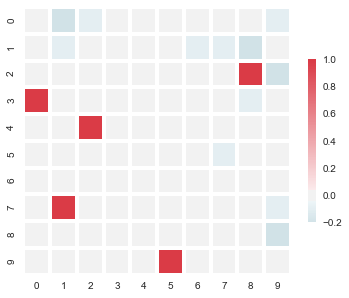

In [13]:
sns.set(style="white")

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(6, 6))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(grid, cmap=cmap, vmax=1, center=0,
            square=True, linewidth=3, cbar_kws={"shrink": .5})

plt.show()